In [ ]:
import os
os.chdir('/content/drive/MyDrive/dirclip-private/core')

In [ ]:
%%capture
!pip install dm-haiku==0.0.10

In [ ]:
import operator as op
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import vmap, pmap
from jax.lax import psum
from jax.tree_util import tree_map, tree_reduce, tree_leaves
import models, datasets, distributions, utils

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
n_dev = jax.device_count()
print(f'{n_dev=}')

n_dev=8


In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [ ]:
# load dataset
ds_name = 'cifar10'
x_train, y_train, n_class = datasets.load(ds_name, 'train')
x_test,  y_test,  n_class = datasets.load(ds_name, 'test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteSQ41YZ/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteSQ41YZ/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# load model
key = jax.random.PRNGKey(0)
net_fn = models.make_resnet20_fn(n_class)
predict_fn, params_init = models.make_nn(net_fn, key, x_train[:1])

In [ ]:
# load weights
model_repr = 'model=resnet20,ds=cifar10,samples=None,distribution=categorical-0,std=0.1,posterior=True,T=0,augment=True,seed=0,'
chain = jnp.load(f'../data/weights/{model_repr}/chain.npy', allow_pickle=True).item()

# get three sets of params for loss landscape plots
s0, s1, s2 = (tree_map(lambda x: x[i], chain) for i in (0, 3, 4))

In [ ]:
def categ_logpdf(logprobs, y):
    batch_size, n_classes = logprobs.shape
    y_one_hot = jax.nn.one_hot(y, n_classes)
    log_prob = (y_one_hot * logprobs).sum(-1)
    return log_prob.mean()

def dir_logpdf(logprobs, y, alpha_prior, posterior=True, clip_logp=None):
    batch_size, n_classes = logprobs.shape
    # y_one_hot = jax.nn.one_hot(y, n_classes)
    # alpha = (alpha_prior+y_one_hot) if posterior else alpha_prior
    # log_prob = ((alpha-1) * logprobs).sum(-1)

    # get prior
    log_probs_clipped = logprobs
    if clip_logp is not None: log_probs_clipped = log_probs_clipped.clip(min=clip_logp)
    log_prior = ((alpha_prior-1) * log_probs_clipped).sum(-1)
    log_prob = log_prior

    # get likelihood
    if posterior:
        y_one_hot = jax.nn.one_hot(y, n_class)
        log_like = (y_one_hot * logprobs).sum(-1)
        log_prob += log_like

    return log_prob.mean()

def ndg_post_logpdf(logprobs, y, alpha_prior):
    # apply the guassian approximation over logprobs (rather than logits)
    batch_size, n_classes = logprobs.shape
    y_one_hot = jax.nn.one_hot(y, n_classes)
    alpha = alpha_prior + y_one_hot # [batch_size, n_classes]
    var = jnp.log(1 / alpha + 1) # [batch_size, n_classes]
    mean = jnp.log(alpha) - var / 2 # [batch_size, n_classes]
    mean -= mean.max() # logprobs are (-inf, 0)
    log_posterior = ((-0.5 * (logprobs - mean)**2 / var)).sum(-1)
    return log_posterior.mean()

def ndg_prior_logpdf(logp, alpha):
    alpha = jnp.array([alpha, 1+alpha])
    var = jnp.log(1 / alpha + 1)
    mu = jnp.log(alpha) - var / 2
    mu -= mu[1] # set mu1 to 0
    return (-0.5 * (logp - mu[0])**2 / var[0]).sum(-1).mean()

def ndg_like_logpdf(logp, y, alpha):
    alpha = jnp.array([alpha, 1+alpha])
    var = jnp.log(1 / alpha + 1)
    mu = jnp.log(alpha) - var / 2
    mu -= mu[1] # set mu1 to 0
    a = (var[0]*mu[1]-var[1]*mu[0]) / (var[0]*var[1])
    b = (var[1]-var[0])/(2*var[0]*var[1])
    batch_size, n_classes = logp.shape
    y_one_hot = jax.nn.one_hot(y, n_classes)
    log_like = (y_one_hot * logp).sum(-1)
    return (a*log_like + b*log_like**2).mean()

def get_jac_correction(x, params, predict_fn):
    def corr_per_sample(x):
        predict_fn_single = lambda params: predict_fn(x[None], params)[0]
        jac = jax.jacrev(predict_fn_single)(params)
        jac = jnp.concatenate(tree_map(lambda x: x.reshape(n_class, -1), tree_leaves(jac)), 1)
        singular_values = jnp.linalg.svd(jac, compute_uv=False)
        model_correction = jnp.log(singular_values).sum()
        return model_correction
    return vmap(corr_per_sample)(x).mean()

def normal_logpdf(params, std=1):
    dx = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), params))
    log_prob = -0.5 * dx / std**2
    return log_prob

In [ ]:
%%time
margin = 1.3

def eval_landscape(s0, s1, s2, predict_fn, ds_size=1_200, grid_size=400):
    # grid of relative coordinates
    rx = jnp.linspace(-1-margin, 1+margin, grid_size)
    ry = jnp.linspace(-margin, 1+margin, grid_size)

    # grid of coordinates in params space
    mean = lambda *args: sum(args) / len(args)
    sm = tree_map(mean, s0, s1)
    dx = tree_map(op.sub, s1, sm)
    dy = tree_map(op.sub, s2, sm)

    # subsample data to seed up computation
    key = jax.random.PRNGKey(0)
    idx = jax.random.choice(key, len(x_train), [ds_size], replace=False)
    x, y = x_train[idx], y_train[idx]

    # split dataset into batches
    x_batched, y_batched = utils.split_into_batches(x, y, n=n_dev)

    # evaluate grid
    def eval_grid(x, y):
        def g(i):
            iy, ix = divmod(i, grid_size)
            s = tree_map(lambda sm, dx, dy: sm + rx[ix]*dx + ry[iy]*dy, sm, dx, dy)
            logits = predict_fn(x, s)
            logprobs = jax.nn.log_softmax(logits)
            out_dict = {
                'norm_prior': normal_logpdf(s, std=0.1),
                'acc': (logprobs.argmax(-1)==y).mean(),
                'max_prob': logprobs.max(-1).mean(),
                'min_prob': logprobs.min(-1).mean(),
                'categ': categ_logpdf(logprobs, y),
                'dir_prior': dir_logpdf(logprobs, y, 0.8, posterior=False),
                'dirclip_prior': dir_logpdf(logprobs, y, 0.8, posterior=False, clip_logp=-50),
                'ndg_post': ndg_post_logpdf(logprobs, y, 1e-6),
                'ndg_prior': ndg_prior_logpdf(logprobs, 1e-6),
                'ndg_like': ndg_like_logpdf(logprobs, y, 1e-6),
                # 'jac_corr': get_jac_correction(x, s, predict_fn)
            }
            return out_dict
        return jax.lax.map(g, jnp.arange(grid_size**2))
    grids = pmap(eval_grid)(x_batched, y_batched)
    grids = {k:v.mean(0).reshape((grid_size, grid_size)) for k, v in grids.items()}
    return grids

grids = eval_landscape(s0, s1, s2, predict_fn)

CPU times: user 1min 56s, sys: 5min 21s, total: 7min 18s
Wall time: 15min 38s


In [ ]:
# save dictionary of numpy arrays
grids_np = {k:np.array(v) for k, v in grids.items()}
np.save('../data/grids_400.npy', grids_np)

# pdf diverges

In [ ]:
%%time
# vary one model parameter, keep other params fixed
param_values = jnp.linspace(-100, 100, 200)
alpha_prior = 1e-4
def f(x):
    s = tree_map(lambda x:x, s0) # create copy
    s['linear']['b'] = s['linear']['b'].at[0].set(x)
    logits = predict_fn(x_train[:1], s)
    logprobs = jax.nn.log_softmax(logits)
    out_dict = {
        'norm': normal_logpdf(s),
        'categ': categ_logpdf(logprobs, y_train[:1]),
        'dir_prior': dir_logpdf(logprobs, y_train[:1], alpha_prior, posterior=False),
        'dir_post': dir_logpdf(logprobs, y_train[:1], alpha_prior, posterior=True),
    }
    return out_dict
dens = vmap(f)(param_values)

CPU times: user 589 ms, sys: 376 ms, total: 965 ms
Wall time: 1.58 s


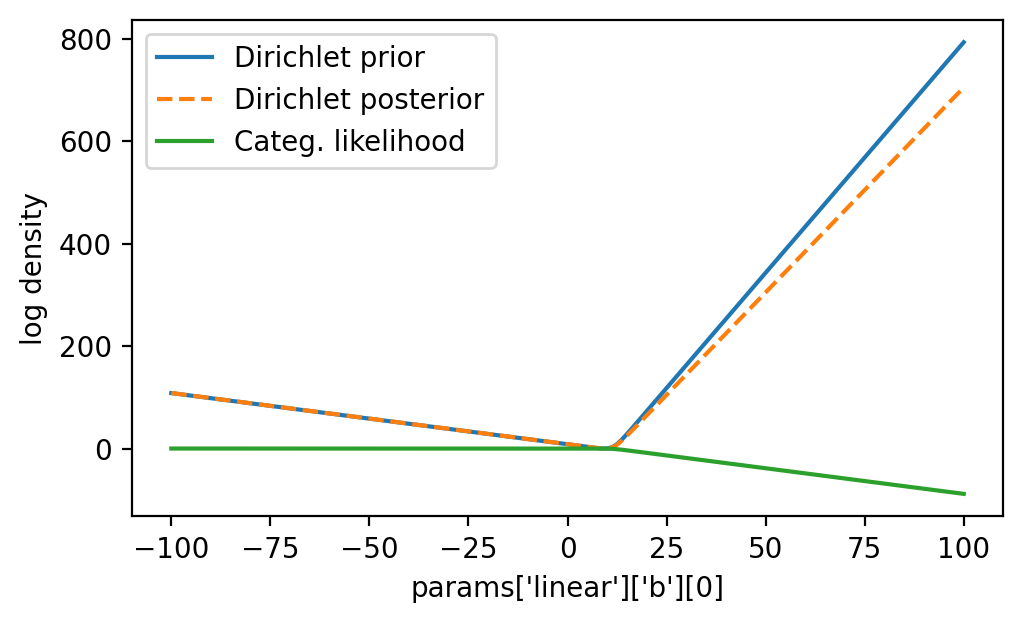

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), layout='compressed')
ax.plot(param_values, dens['dir_prior']-dens['dir_prior'].min(), label='Dirichlet prior')
ax.plot(param_values, dens['dir_post']-dens['dir_post'].min(), ls='--', label='Dirichlet posterior')
ax.plot(param_values, dens['categ']-dens['categ'].max(), label='Categ. likelihood')
# ax.plot(param_values, dens['norm'], label='Normal prior')
ax.legend()
ax.set_xlabel("params['linear']['b'][0]")
# ax.set_ylabel('$\log p_\mathregular{ND}(w|D)$')
ax.set_ylabel('log density')
# ax.yaxis.get_major_formatter().set_useOffset(False)
plt.savefig('../plots/dirichlet_density_diverging.pdf')
plt.show()